In [27]:
import matplotlib.pyplot as plt
import numpy as np
import gymnasium as gym
import sys
sys.path.append('..')
from data_utils import get_nth_episode_info
from IPython.display import clear_output
from sapien.core import Pose
from mani_skill2.envs.pick_and_place.base_env import StationaryManipulationEnv
from mani_skill2.utils.registration import register_env
import gymnasium as gym
import sapien.core as sapien
from mani_skill2 import ASSET_DIR
from pathlib import Path
from typing import Dict, List
from mani_skill2 import format_path
from mani_skill2.utils.io_utils import load_json
import numpy as np
from sapien.core import Pose
import matplotlib.pyplot as plt
import time

# Register ManiSkill2 environments in gym
import mani_skill2.envs
from mani_skill2 import ASSET_DIR
from mani_skill2.utils.sapien_utils import look_at


from mani_skill2.utils.registration import register_env

from mani_skill2.envs.pick_and_place.pick_cube import PickCubeEnv
from mani_skill2.envs.pick_and_place.stack_cube import StackCubeEnv
from mani_skill2.envs.pick_and_place.pick_single import PickSingleYCBEnv
from mani_skill2.envs.pick_and_place.pick_clutter import PickClutterYCBEnv
from mani_skill2.envs.assembly.peg_insertion_side import PegInsertionSideEnv
from mani_skill2.envs.assembly.plug_charger import PlugChargerEnv
from mani_skill2.envs.assembly.assembling_kits import AssemblingKitsEnv
from mani_skill2.envs.misc.turn_faucet import TurnFaucetEnv
from mani_skill2.envs.ms1.push_chair import PushChairEnv
from mani_skill2.envs.ms1.open_cabinet_door_drawer import OpenCabinetDoorEnv, OpenCabinetDrawerEnv
from mani_skill2.envs.ms1.move_bucket import MoveBucketEnv

from mani_skill2.utils.sapien_utils import hex2rgba
from mani_skill2.sensors.camera import CameraConfig

from transforms3d.euler import euler2quat, quat2euler
from mani_skill2.envs.pick_and_place.pick_cube import PickCubeEnv
import itertools
from glob import glob
from config import ycb_heights

In [609]:
# register cube / sphere / YCB objects
def register_objects(configs):
    """
        Configs: dict[
            "name": "cube" / "sphere" / "002_master_chef_can"
            "scale": float or none
            "color": tuple or none
        ]
    """
    @register_env("CustomEnv-v0", max_episode_steps=200, override=True)
    class CustomEnv(PickCubeEnv):
        def _load_actors(self):
            self._add_ground(render=self.bg_name is None)
            objs = []
            for i, config in enumerate(configs):
                obj = build_asset(self, config)
                if i == 0:
                    self.obj = obj
                objs.append(obj)

            self.objs = objs
            self.goal_site = self._build_sphere_site(self.goal_thresh)

        def _register_cameras(self):
            pose = look_at([-0.5, 0, 1], [0, 0, 0])
            return CameraConfig(
                "base_camera", pose.p, pose.q, 512, 512, 1.4, 0.01, 10
            )
        
def build_asset(self, config):
    scale = config["scale"]
    if config["name"] == "cube":
        obj = self._build_cube(self.cube_half_size*scale, color=config["color"], static=config["static"])

    else:
        scale *= self.cube_half_size / 0.01887479572529618
        filepath = config["name"]
        model_dir = Path(filepath).resolve()
        # model_dir = ".." / ASSET_DIR / "mani_skill2_ycb/models/011_banana"
        builder = self._scene.create_actor_builder()

        collision_file = str(model_dir / "collision.obj")
        builder.add_multiple_collisions_from_file(
            filename=collision_file, scale=scale, density=1000
        )
        visual_file = str(model_dir / "textured.obj")
        builder.add_visual_from_file(filename=visual_file, scale=scale)
        # builder.add_box_visual()
        if config["static"]:
            obj = builder.build_static(name=filepath.split("/")[-1])
        else:
            obj = builder.build(name=filepath.split("/")[-1])
            obj.lock_motion(False, False, False, True, True, True)

    return obj

In [610]:
model_paths = sorted(glob("../data/mani_skill2_ycb/models/*"), key=lambda x: int(x.split('/')[-1][:3]))

configs = [{
    "name": "cube",
    "scale": 5,
    "color": (0.5, 0.5, 0.5),
    "static": True
},{
    "name": model_paths[0],
    "scale": 2,
    "static": True
},
{
    "name": model_paths[1],
    "scale": 2,
    "static": True
},
{
    "name": model_paths[-1],
    "scale": 2,
    "static": True
},

]

register_objects(configs)

2024-03-12 15:18:11,140 - mani_skill2 - WARNING - Override registered env CustomEnv-v0


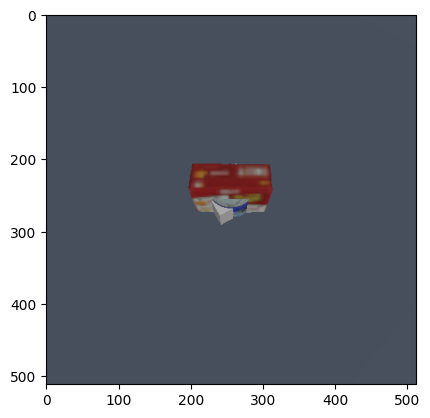

In [653]:
env = gym.make("CustomEnv-v0", obs_mode="rgbd", camera_cfgs={"add_segmentation": True})
env.reset()

for _ in range(1):  # Simulate for 1 second
    obs, _, _, _, _ = env.step(np.zeros(len(env.action_space.sample())))
    clear_output(wait=True)
    plt.imshow(obs['image']['base_camera']['rgb'])
    plt.show()
    # time.sleep(1)

In [654]:
# initalize randomly
    # make sure they don't overlap
    # for moving left and right, make sure there is enough distance.

In [655]:
# move one object to a new position
def is_overlapping(pos1, pos2, min_dist):
    # Calculate the Euclidean distance between two positions
    dist = np.sqrt((pos1[0] - pos2[0])**2 + (pos1[1] - pos2[1])**2)
    return dist < min_dist

def generate_non_overlapping_position(existing_positions, min_dist, low=-0.5, high=0.5):
    while True:
        # Generate a random position
        new_position = np.random.uniform(low=low, high=high, size=(2))
        # Check for overlap with existing positions
        overlap = any(is_overlapping(new_position, pos, min_dist) for pos in existing_positions)
        if not overlap:
            return new_position

def initialize_positions(configs, low=-0.5, high=0.5, min_dist=0.5):
    existing_positions = []

    for move_idx in range(len(configs)):
        position = generate_non_overlapping_position(existing_positions, min_dist, low, high)
        existing_positions.append(position)

        quat = euler2quat(0, 0, np.random.uniform(-np.pi*2, np.pi*2))
        name = configs[move_idx]["name"]
        if name == "cube":
            new_pose = Pose([position[0], position[1], env.unwrapped.cube_half_size[-1]*2], quat)
        else:
            model_name = name.split('/')[-1]
            scale = configs[move_idx]["scale"]
            new_pose = Pose([position[0], position[1], ycb_heights[model_name]*scale], quat)

        env.unwrapped.objs[move_idx].set_pose(new_pose)


# move cube
def place_object_in_direction(env, obj, direction, distance=0.5):
    pose_obj = obj.get_pose()
    if direction == "forward":
        new_position_obj = [pose_obj.p[0] - distance, pose_obj.p[1], pose_obj.p[2]]
    elif direction == "backward":
        new_position_obj = [pose_obj.p[0] + distance, pose_obj.p[1], pose_obj.p[2]]
    elif direction == "right":
        new_position_obj = [pose_obj.p[0], pose_obj.p[1] - distance, pose_obj.p[2]]
    elif direction == "left":
        new_position_obj = [pose_obj.p[0], pose_obj.p[1] + distance, pose_obj.p[2]]

    obj.set_pose(Pose(new_position_obj, obj.get_pose().q))


In [718]:
def place_object_on_another(env, obj1, obj2, direction, distance=0.5):
    pose_obj2 = obj2.get_pose()
    pose_obj1 = obj1.get_pose()
    
    if direction == "front":
        new_position_obj1 = [pose_obj2.p[0] - distance, pose_obj2.p[1], pose_obj2.p[2]]
    elif direction == "behind":
        new_position_obj1 = [pose_obj2.p[0] + distance, pose_obj2.p[1], pose_obj2.p[2]]
    elif direction == "right":
        new_position_obj1 = [pose_obj2.p[0], pose_obj2.p[1] - distance, pose_obj2.p[2]]
    elif direction == "left":
        new_position_obj1 = [pose_obj2.p[0], pose_obj2.p[1] + distance, pose_obj2.p[2]]
    elif direction == "top":
        new_position_obj1 = [pose_obj2.p[0], pose_obj2.p[1], pose_obj2.p[2]*2 + pose_obj1.p[2]]
        
    obj1.set_pose(Pose(new_position_obj1, obj1.get_pose().q))

def place_object_in_between(env, obj_to_move, obj1, obj2):
    pose_obj1 = obj1.get_pose().p
    pose_obj2 = obj2.get_pose().p
    
    new_position = Pose((pose_obj1 + pose_obj2) / 2, obj_to_move.get_pose().q)

    obj_to_move.set_pose(new_position)

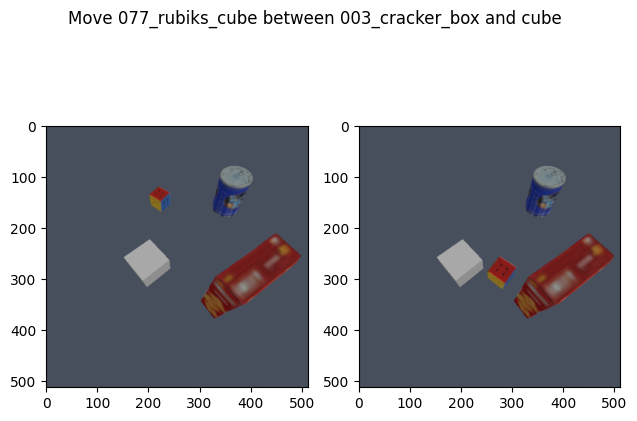

True


In [726]:
min_distance = 0.5
initialize_positions(configs, min_dist=min_distance)

fig, axs = plt.subplots(1, 2)
obs, _, _, _, _ = env.step(np.zeros(len(env.action_space.sample())))
axs[0].imshow(obs['image']['base_camera']['rgb'])

one_obj_directions = ["forward", "backward", "right", "left"]
two_objs_directions = ["front", "behind", "right", "left", "top"]

# single_rand = np.random.choice(np.arange(len(configs)), 1)
# rand = np.random.choice(np.arange(len(configs)), 2, replace=False)

# obj1 = env.unwrapped.objs[rand[0]]
# obj2 = env.unwrapped.objs[rand[1]]
# obj3 = env.unwrapped.objs[single_rand[0]]


# one_obj_direction = np.random.choice(one_obj_directions)
# place_object_in_direction(env, obj1, one_obj_direction, 0.4)

# two_objs_direction = np.random.choice(two_objs_directions)
# place_object_on_another(env, obj2, obj3, two_objs_direction, 0.3)


rand = np.random.choice(np.arange(len(configs)), 3, replace=False)
obj1 = env.unwrapped.objs[rand[0]]
obj2 = env.unwrapped.objs[rand[1]]
obj3 = env.unwrapped.objs[rand[2]]
place_object_in_between(env, obj1, obj2, obj3)

obs, _, _, _, _ = env.step(np.zeros(len(env.action_space.sample())))
axs[1].imshow(obs['image']['base_camera']['rgb'])
# plt.suptitle(f"Move {obj1.name} {one_obj_direction} and {obj2.name} {two_objs_direction} of {obj3.name}")
plt.suptitle(f"Move {obj1.name} between {obj2.name} and {obj3.name}")
plt.tight_layout()
plt.show()

# make sure all objects are present
ids = [obj.id for obj in env.unwrapped.objs]

all_present = np.all(np.isin(ids, np.unique(obs['image']['base_camera']["Segmentation"])))
print(all_present)
